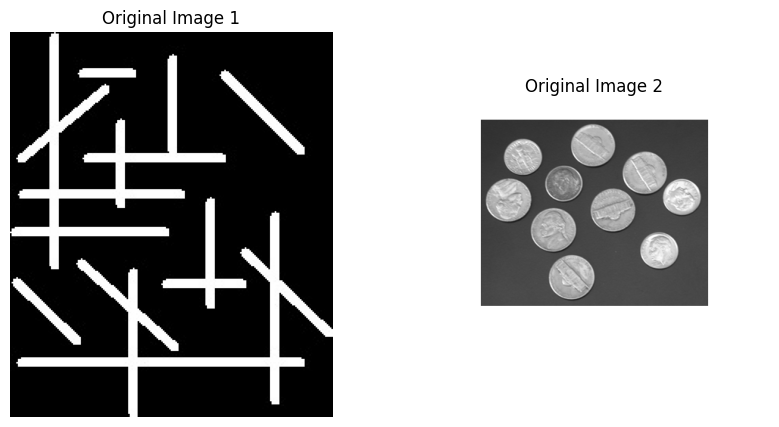

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image1 = cv2.imread("Lanes.jpeg")  
image2 = cv2.imread("DetectEdgesInImages.png")  


gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)


plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title("Original Image 1")
plt.axis("off")


plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title("Original Image 2")
plt.axis("off")

plt.show()


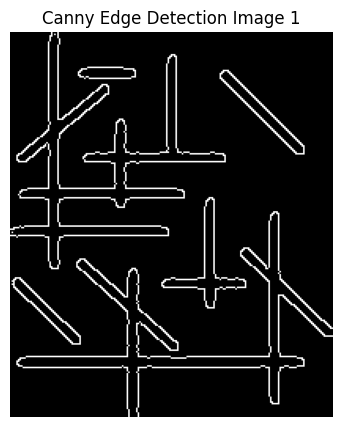

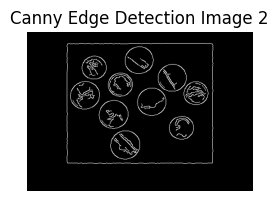

In [3]:

blurred1 = cv2.GaussianBlur(gray1, (5, 5), 0)
blurred2 = cv2.GaussianBlur(gray2, (5, 5), 0)


edges1 = cv2.Canny(blurred1, 50, 150, apertureSize=3)
edges2 = cv2.Canny(blurred2, 50, 150, apertureSize=3)


plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.imshow(edges1, cmap="gray")
plt.title("Canny Edge Detection Image 1")
plt.axis("off")
plt.show()

plt.subplot(1,2,2)
plt.imshow(edges2, cmap="gray")
plt.title("Canny Edge Detection Image 2")
plt.axis("off")

plt.show()


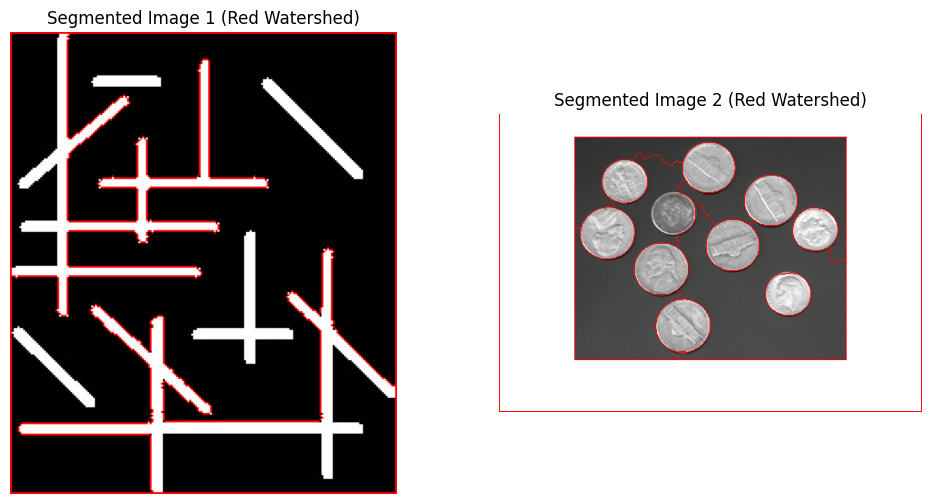

In [4]:

hsv1 = cv2.cvtColor(image1, cv2.COLOR_BGR2HSV)
hsv2 = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)
gray1 = hsv1[:, :, 2]  # Use the V channel as grayscale
gray2 = hsv2[:, :, 2]
def apply_watershed(image, gray):
    

    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


    kernel = np.ones((3, 3), np.uint8)
    sure_bg = cv2.dilate(thresh, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)


    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)


    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0


    image_copy = image.copy()
    cv2.watershed(image_copy, markers)
    

    image_copy[markers == -1] = [0, 0, 255]
    return image_copy


segmented1 = apply_watershed(image1, gray1)
segmented2 = apply_watershed(image2, gray2)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(cv2.cvtColor(segmented1, cv2.COLOR_BGR2RGB))
axes[0].set_title("Segmented Image 1 (Red Watershed)")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(segmented2, cv2.COLOR_BGR2RGB))
axes[1].set_title("Segmented Image 2 (Red Watershed)")
axes[1].axis("off")

plt.show()


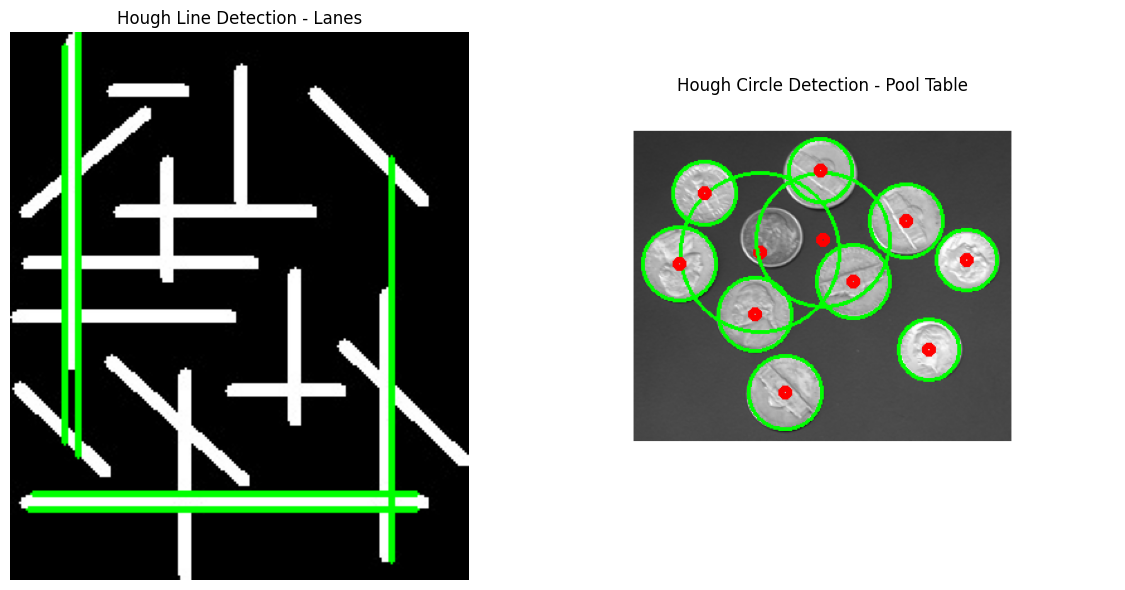

In [12]:

def detect_lines(image, edges):
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=150)
    image_lines = image.copy()
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image_lines, (x1, y1), (x2, y2), (0, 255, 0), 2) 

    return image_lines


def detect_circles(image, gray):
    image_circles = image.copy()
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=40, param1=50, param2=50, minRadius=20, maxRadius=80)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(image_circles, (i[0], i[1]), i[2], (0, 255, 0), 2)  
            cv2.circle(image_circles, (i[0], i[1]), 3, (0, 0, 255), 3)   

    return image_circles


image1_lines = detect_lines(image1, edges1)
image2_circles = detect_circles(image2, gray2)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(cv2.cvtColor(image1_lines, cv2.COLOR_BGR2RGB))
axes[0].set_title("Hough Line Detection - Lanes")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(image2_circles, cv2.COLOR_BGR2RGB))
axes[1].set_title("Hough Circle Detection - Pool Table")
axes[1].axis("off")

plt.tight_layout()
plt.show()


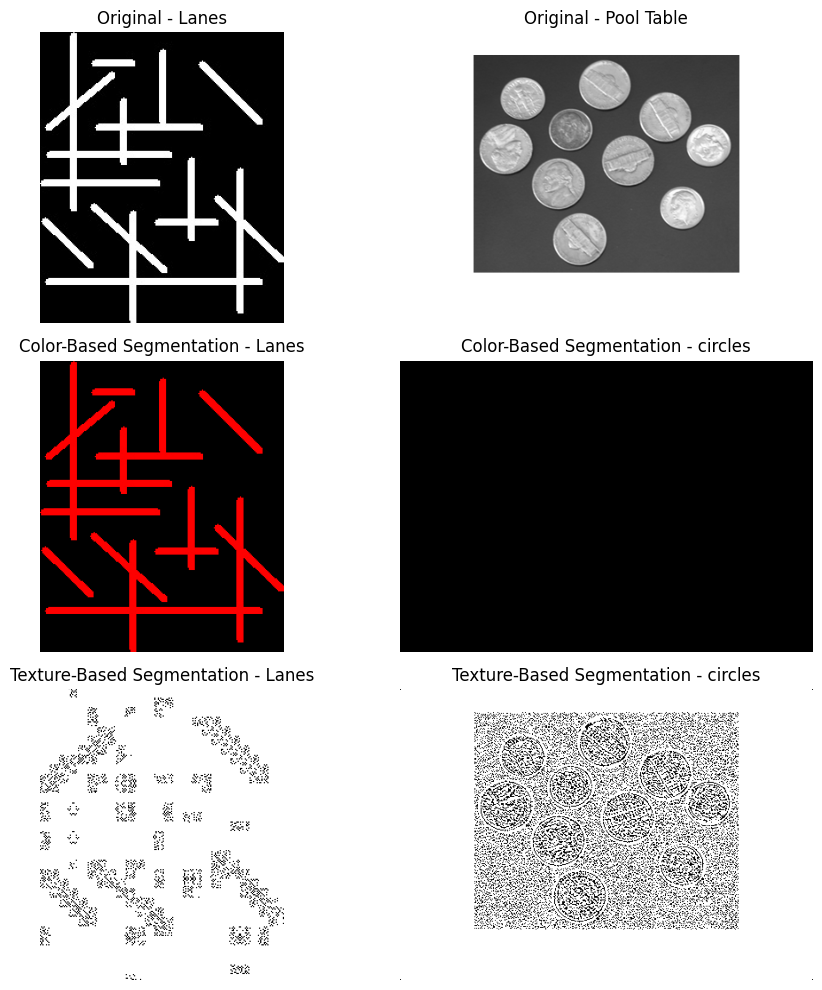

In [3]:
from skimage.filters import gabor
from skimage.feature import local_binary_pattern


image_lanes = cv2.imread("Lanes.jpeg")  
image_pool = cv2.imread("DetectEdgesInImages.png")


hsv_lanes = cv2.cvtColor(image_lanes, cv2.COLOR_BGR2HSV)
hsv_pool = cv2.cvtColor(image_pool, cv2.COLOR_BGR2HSV)


def color_segmentation(image, lower_range, upper_range):
    mask = cv2.inRange(image, lower_range, upper_range)
    segmented = cv2.bitwise_and(image, image, mask=mask)
    return segmented, mask


lower_white = np.array([0, 0, 200])   
upper_white = np.array([180, 50, 255])

lower_green = np.array([35, 40, 40]) 
upper_green = np.array([85, 255, 255])


lanes_color_seg, lanes_mask = color_segmentation(hsv_lanes, lower_white, upper_white)
pool_color_seg, pool_mask = color_segmentation(hsv_pool, lower_green, upper_green)


def texture_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    

    gabor_filtered, _ = gabor(gray, frequency=0.6)
    

    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    

    gabor_norm = cv2.normalize(gabor_filtered, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    lbp_norm = cv2.normalize(lbp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    

    texture_combined = cv2.addWeighted(gabor_norm, 0.5, lbp_norm, 0.5, 0)
    
    _, texture_mask = cv2.threshold(texture_combined, 50, 255, cv2.THRESH_BINARY)
    
    return texture_combined, texture_mask


lanes_texture_seg, lanes_texture_mask = texture_segmentation(image_lanes)
pool_texture_seg, pool_texture_mask = texture_segmentation(image_pool)


fig, axes = plt.subplots(3, 2, figsize=(10, 10))


axes[0, 0].imshow(cv2.cvtColor(image_lanes, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Original - Lanes")

axes[0, 1].imshow(cv2.cvtColor(image_pool, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title("Original - Pool Table")

axes[1, 0].imshow(cv2.cvtColor(lanes_color_seg, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title("Color-Based Segmentation - Lanes")

axes[1, 1].imshow(cv2.cvtColor(pool_color_seg, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title("Color-Based Segmentation - circles")

axes[2, 0].imshow(lanes_texture_mask, cmap="gray")
axes[2, 0].set_title("Texture-Based Segmentation - Lanes")

axes[2, 1].imshow(pool_texture_mask, cmap="gray")
axes[2, 1].set_title("Texture-Based Segmentation - circles")


for ax in axes.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 45s 0us/step


/Users/n1kk_08/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.0727 - loss: 4.1630 - val_accuracy: 0.1927 - val_loss: 3.4047
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.2336 - loss: 3.1747 - val_accuracy: 0.2783 - val_loss: 2.9626
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.3039 - loss: 2.8113 - val_accuracy: 0.3101 - val_loss: 2.7991
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.3470 - loss: 2.5785 - val_accuracy: 0.3412 - val_loss: 2.6611
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.3891 - loss: 2.4078 - val_accuracy: 0.3496 - val_loss: 2.6073
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4157 - loss: 2.2746 - val_accuracy: 0.3596 - val_loss: 2.5598
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4363 - loss: 2.1748 - val_accuracy: 0.3597 - val_loss: 2.5733
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4629 - loss: 2.0562 - 

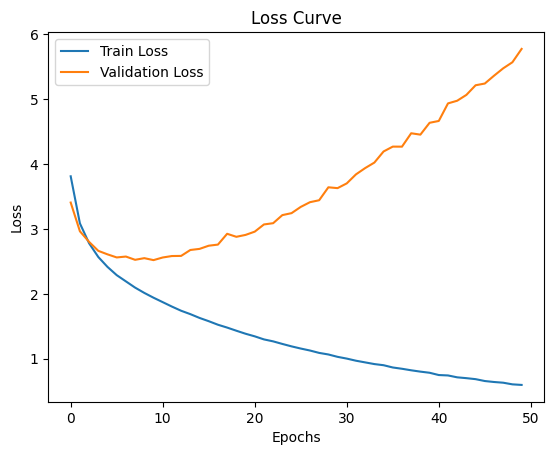

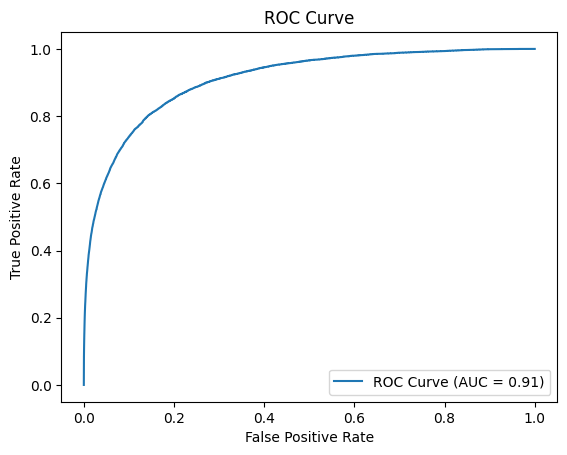

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


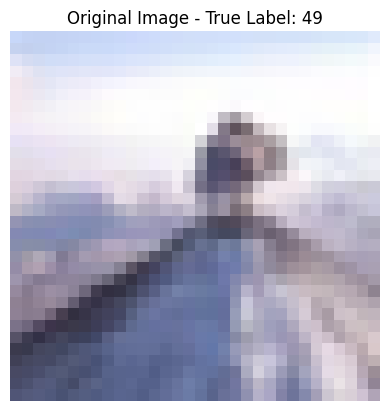

Predicted Label: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


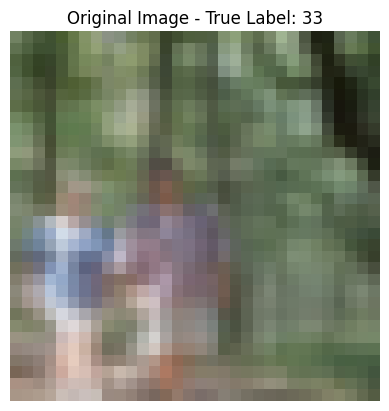

Predicted Label: 80


In [13]:
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical


(x_train, y_train), (x_test, y_test) = cifar100.load_data()


x_train, x_test = x_train / 255.0, x_test / 255.0


num_classes = 100
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(num_classes, activation="softmax") 
])


model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test))


loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")


y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


report = classification_report(y_true, y_pred, output_dict=True)
precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
f1_score = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()


fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


def predict_and_show(image_index):
    test_image = np.expand_dims(x_test[image_index], axis=0) 
    prediction = model.predict(test_image)
    predicted_label = np.argmax(prediction)


    plt.imshow(x_test[image_index])
    plt.title(f"Original Image - True Label: {y_true[image_index]}")
    plt.axis("off")
    plt.show()

    print(f"Predicted Label: {predicted_label}")


predict_and_show(0)
predict_and_show(1)



image 1/1 /Users/n1kk_08/Downloads/ACV-Labs/temp1.png: 640x544 (no detections), 109.8ms
Speed: 3.7ms preprocess, 109.8ms inference, 509.9ms postprocess per image at shape (1, 3, 640, 544)

📌 Objects detected in temp1.png:


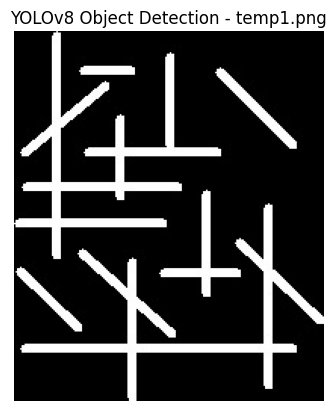


image 1/1 /Users/n1kk_08/Downloads/ACV-Labs/temp2.png: 480x640 6 bowls, 1 dining table, 228.2ms
Speed: 1.6ms preprocess, 228.2ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)

📌 Objects detected in temp2.png:
🔹 bowl: 0.71
🔹 bowl: 0.53
🔹 dining table: 0.33
🔹 bowl: 0.31
🔹 bowl: 0.30
🔹 bowl: 0.28
🔹 bowl: 0.28


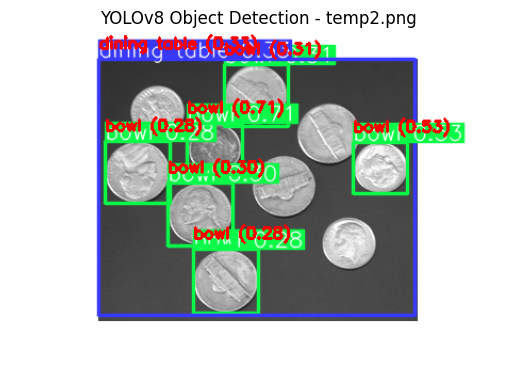

In [6]:
from ultralytics import YOLO
import os


model = YOLO("yolov8n.pt")


def detect_and_show(image, temp_filename="temp_image.jpg"):

    if image is None:
        print("❌ Error: Image is not loaded properly.")
        return


    cv2.imwrite(temp_filename, image)


    results = model.predict(temp_filename, save=False, verbose=True)


    for r in results:
        image_with_boxes = r.plot()
        

        print(f"\n📌 Objects detected in {temp_filename}:")
        for box in r.boxes.data:
            x1, y1, x2, y2, confidence, class_id = box.tolist()
            class_name = model.names[int(class_id)] 
            print(f"🔹 {class_name}: {confidence:.2f}")


            label = f"{class_name} ({confidence:.2f})"
            cv2.putText(image_with_boxes, label, (int(x1), int(y1) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


    plt.imshow(image_with_boxes)
    plt.title(f"YOLOv8 Object Detection - {temp_filename}")
    plt.axis("off")
    plt.show()


    os.remove(temp_filename)


image1 = cv2.imread("Lanes.jpeg") 
image2 = cv2.imread("DetectEdgesInImages.png")  


if image1 is None or image2 is None:
    print("❌ Error: Could not load one or both images. Check file paths.")
else:
    detect_and_show(image1, "temp1.png")
    detect_and_show(image2, "temp2.png")


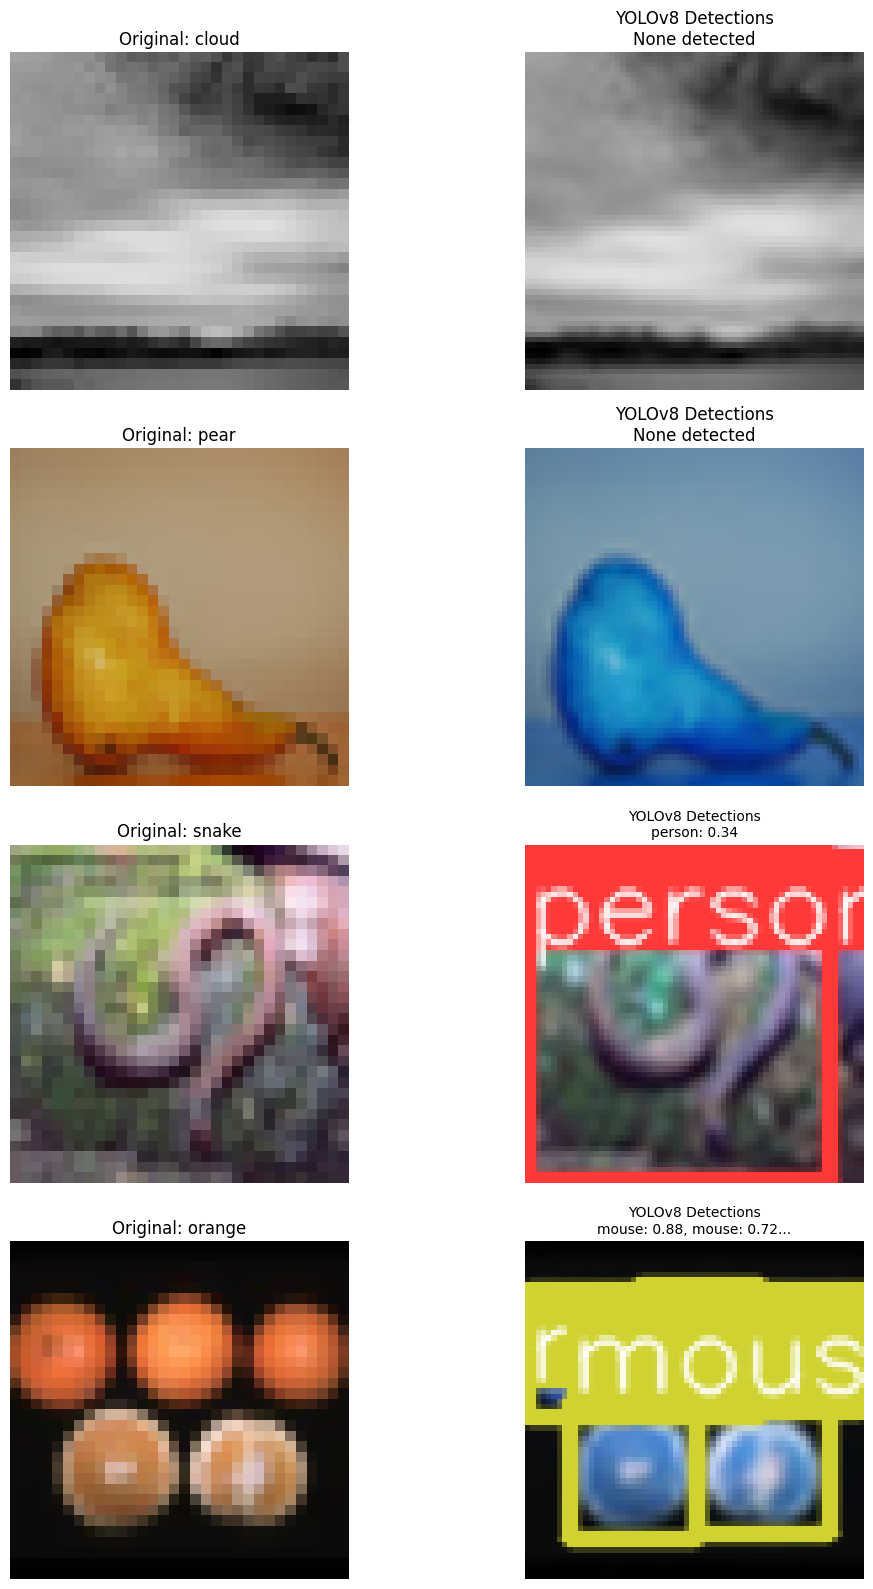


----- CIFAR-100 Detection Details -----

Image 1: CIFAR-100 class 'cloud'
YOLOv8 detected: None

Image 2: CIFAR-100 class 'pear'
YOLOv8 detected: None

Image 3: CIFAR-100 class 'snake'
YOLOv8 detected:
  - person: 0.27

Image 4: CIFAR-100 class 'orange'
YOLOv8 detected:
  - mouse: 0.88
  - mouse: 0.84
  - mouse: 0.49
  - mouse: 0.44
  - mouse: 0.40


In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from ultralytics import YOLO
import random

# Load the YOLOv8 model
model = YOLO("yolov8n.pt")  # Using YOLOv8 nano (smallest version)

# Load CIFAR-100 dataset (Using Local Version)
transform = transforms.Compose([
    transforms.ToTensor()
])

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=False, transform=transform)

# Get CIFAR-100 class names
cifar100_classes = testset.classes

# Function to convert tensor to OpenCV image
def tensor_to_cv2(tensor):
    img_np = tensor.permute(1, 2, 0).numpy()
    img_np = (img_np * 255).astype(np.uint8)
    img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    return img_cv2

# Function to detect objects in CIFAR images with upscaling
def detect_objects_cifar(image_tensor, cifar_class, scale_factor=5):
    # Convert tensor to OpenCV format
    image_cv2 = tensor_to_cv2(image_tensor)
    
    # Store original small image for display
    original_image = cv2.cvtColor(image_cv2.copy(), cv2.COLOR_BGR2RGB)
    
    # Upscale image using a high-quality interpolation method
    width = image_cv2.shape[1] * scale_factor
    height = image_cv2.shape[0] * scale_factor
    upscaled_image = cv2.resize(image_cv2, (width, height), interpolation=cv2.INTER_CUBIC)

    # Convert OpenCV image to RGB format
    upscaled_rgb = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2RGB)

    # Perform object detection on upscaled image (Directly from numpy array)
    results = model.predict(upscaled_rgb, save=False, verbose=False)

    # Process results
    detections = []
    for r in results:
        image_with_boxes = r.plot()
        
        # Collect detection information
        if len(r.boxes) > 0:
            for box in r.boxes.data:
                x1, y1, x2, y2, confidence, class_id = box.tolist()
                class_name = model.names[int(class_id)]
                detections.append(f"{class_name}: {confidence:.2f}")

    return original_image, cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB), detections, cifar_class

# Sample random images from CIFAR-100
num_samples = 4
sample_indices = random.sample(range(len(testset)), num_samples)

# Create plot - for each sample show original and detection side by side
fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))

for i, idx in enumerate(sample_indices):
    # Get image and label
    image, label = testset[idx]
    class_name = cifar100_classes[label]
    
    # Apply YOLOv8 with upscaling
    original, result_image, detections, cifar_class = detect_objects_cifar(image, class_name,2)
    
    # Display original image with actual class
    axes[i, 0].imshow(original)
    axes[i, 0].set_title(f"Original: {cifar_class}")
    axes[i, 0].axis("off")
    
    # Display detection results
    axes[i, 1].imshow(result_image)
    det_title = f"YOLOv8 Detections"
    if detections:
        det_text = ", ".join(detections[:2])  # Limit to first 2 detections
        if len(detections) > 2:
            det_text += "..."
        axes[i, 1].set_title(f"{det_title}\n{det_text}", fontsize=10)
    else:
        axes[i, 1].set_title(f"{det_title}\nNone detected")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

# Print full detection results
print("\n----- CIFAR-100 Detection Details -----")
for i, idx in enumerate(sample_indices):
    image, label = testset[idx]
    class_name = cifar100_classes[label]
    _, _, detections, cifar_class = detect_objects_cifar(image, class_name)
    
    print(f"\nImage {i+1}: CIFAR-100 class '{cifar_class}'")
    if detections:
        print("YOLOv8 detected:")
        for d in detections:
            print(f"  - {d}")
    else:
        print("YOLOv8 detected: None")



📌 Objects detected in Lanes.png:
🔹 Class 1: 1.00
🔹 Class 1: 0.99
🔹 Class 8: 0.93
🔹 Class 1: 0.76
🔹 Class 3: 0.71
🔹 Class 62: 0.62


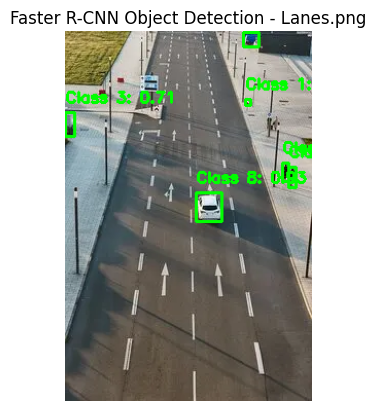


📌 Objects detected in DetectEdgesInImages.png:
🔹 Class 34: 0.78
🔹 Class 34: 0.69


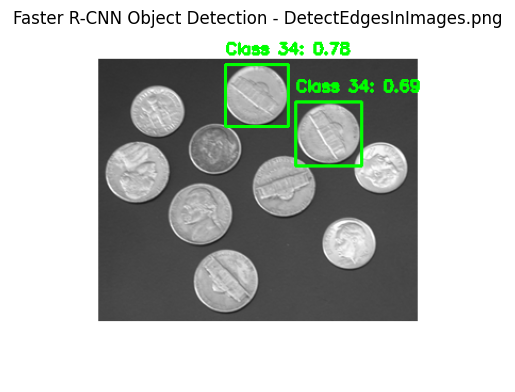

In [8]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import requests


model_frcnn = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_frcnn.eval()


coco_labels_url = "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_labels.txt"
coco_labels = requests.get(coco_labels_url).text.strip().split("\n")


def detect_and_show(image_path, confidence_threshold=0.6):

    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0) 


    with torch.no_grad():
        predictions = model_frcnn(image_tensor)


    image_cv = cv2.imread(image_path)

    print(f"\n📌 Objects detected in {image_path}:")
    
    for i, box in enumerate(predictions[0]["boxes"]):
        score = predictions[0]["scores"][i].item()
        if score > confidence_threshold: 
            x1, y1, x2, y2 = map(int, box)
            class_id = int(predictions[0]["labels"][i].item()) 

            class_name = coco_labels[class_id] if class_id < len(coco_labels) else f"Class {class_id}"


            cv2.rectangle(image_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f"{class_name}: {score:.2f}"
            print(f"🔹 {label}")


            cv2.putText(image_cv, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title(f"Faster R-CNN Object Detection - {image_path}")
    plt.axis("off")
    plt.show()


detect_and_show("Lanes.png") 
detect_and_show("DetectEdgesInImages.png")  
